In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [2]:
with open("CSV_Creation/daily_data_by_country.csv") as f:
    daily_data = pd.read_csv(f,  error_bad_lines=False)

In [3]:
#try to cluster countries in Europe by regarding their last daily death rate and recovery rate 
last_day_nb = daily_data.values[-1, 0]
tested_countries = ['France', 'Denmark', 'Germany', 'United Kingdom', 'Spain', 'Italy', 'Austria', 'Belgium', 'Ireland','Romania', 'Hungary', 'Portugal', 'Switzerland', 'Netherlands']
tested_countries.sort()
last_day_data = daily_data.loc[(daily_data['Country'].isin(tested_countries)) & (daily_data['Day_number']==last_day_nb), ['Country', 'Death_rate', 'Recovery_rate']].groupby('Country').max()
scaled_data = preprocessing.scale(last_day_data)


In [4]:
#implementing the PCA objet for PCA Analysis
pca = PCA()

#training on the scaled_data
pca.fit(scaled_data)

#building of the 2 principal components in this case
pca_data = pca.transform(scaled_data)

#use of the two components to cluster the data
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

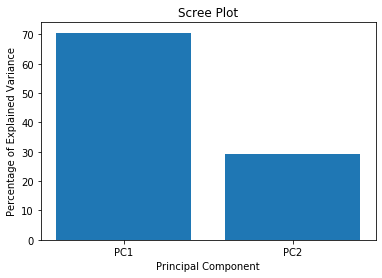

In [5]:
#the scree shot represents the percentage of variation that each principal component accounts for
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

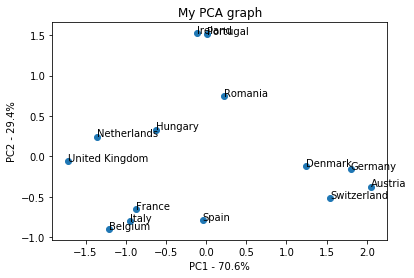

In [6]:
pca_df = pd.DataFrame(pca_data, index=tested_countries, columns=labels)

plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))


for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
    

In [7]:
#an other try with all dead rates and recovered rates from the period
prepared_data = daily_data.loc[daily_data['Country'].isin(tested_countries), :]


In [8]:
#However, PCA algorithm doesn't need 'NaN' data for clustering 
#that is why, the first day that all listed countries had at least one confirmed case is needed 

def last_country_first_case(prepared_data):
    min_day = 0
    country = ''
    needed_data = prepared_data[['Day_number', 'Country', 'Confirmed']].values
    for row in needed_data:
        if row[2] == 0:
            min_day = row[0]
            country = row[1]
    return (min_day, country)

min_day_nb = last_country_first_case(prepared_data)[0]

In [9]:
def construct_data_for_PCA(prepared_data, tested_countries, min_day_nb, last_day_nb):
    needed_data = prepared_data.loc[prepared_data['Day_number']>min_day_nb, ['Country', 'Death_rate', 'Recovery_rate']]
    data = []
    for country in tested_countries:
        l = []
        for row in  needed_data.loc[needed_data['Country'] == country, :].values:
            l.append(row[1])
            l.append(row[2])
        data.append(l)
    list_column = []
    for day in range(min_day_nb + 1, last_day_nb + 1):
        list_column.append('Death_rate_' + str(day))
        list_column.append('Recovery_rate_'+ str(day))
    return pd.DataFrame(np.array(data), columns=list_column, index = tested_countries)

data_for_PCA = construct_data_for_PCA(prepared_data, tested_countries, min_day_nb, last_day_nb)


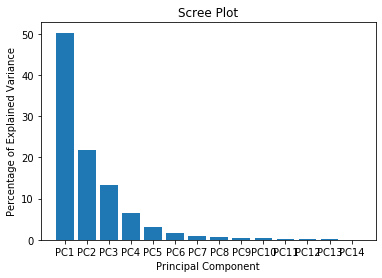

In [10]:
scaled_data = preprocessing.scale(data_for_PCA)
countries = data_for_PCA.index

pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

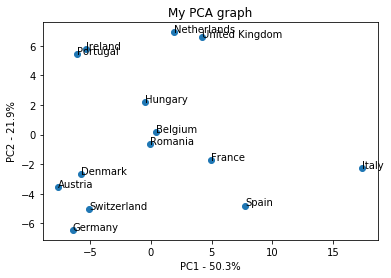

In [11]:
pca_df = pd.DataFrame(pca_data, index=tested_countries, columns=labels)

plt.scatter(pca_df.PC1, pca_df.PC2)
plt.title('My PCA graph')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))

for sample in pca_df.index:
    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))

In [12]:
#contribution of the death_number for establishing the PCA analysis
loading_scores = pd.Series(pca.components_[0], index = data_for_PCA.columns)
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
top_scores = sorted_loading_scores[0:10].index.values

print(loading_scores[top_scores])

Death_rate_64    0.144147
Death_rate_66    0.143265
Death_rate_63    0.143229
Death_rate_68    0.143039
Death_rate_65    0.142795
Death_rate_61    0.142098
Death_rate_67    0.141806
Death_rate_69    0.141766
Death_rate_62    0.141432
Death_rate_70    0.141343
dtype: float64
